<a href="https://colab.research.google.com/github/data-IA-2022/Challenge-ML-Tarik/blob/main/Dev_IA_Challenge_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge ML

**Bienvenue dans le challenge ML !** Il s'agit d'évaluer les compétences acquises pour développer un modèle de Machine Learning.

Vous allez développer un classifieur automatique de Spam grâce à une collection existante de SMS labellisés (Spam / Ham). Ce dataset provient de [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/228/sms+spam+collection).  
Pour ce challenge, voici les étapes sur lesquelles vous serez particulièrement évalué :
- Preprocessing
- Automatisation du process avec un pipeline
- Entrainement et validation croisée des modèles
- Recherche des hyper-paramètres
- Comparaison de différents modèles de classification
- Sélection d'une métrique d'erreur convenablement choisie vis-à-vis du contexte
- Sélection d'un modèle de classification et justification du choix  

Et en bonus :
- Compréhension et analyses des erreurs du modèle
- Compréhension et analyses des caractéristiques (features) d'intérêt
  
**Consignes :**
- Faites une copie de ce notebook et modifiez-le librement.
- Structuer votre notebook afin d'en faire un véritable rapport :
  - Titres, zones de texte et zones de code.
  - Il est important d'apporter des explications et des justifications pour les choix réalisés.
- En fin de challenge, partagez votre travail sur Simplonline (veuillez vous assurer que les accès à votre document sont autorisés à des tiers).



#1.Chargement des librairies

In [77]:
# Data
import pandas as pd
import numpy as np

# Graph
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import text
from sklearn.metrics import recall_score, confusion_matrix, f1_score, accuracy_score

# time
import time


#2.Chargement de la collection de SMS

In [3]:
url = "https://raw.githubusercontent.com/remijul/dataset/master/SMSSpamCollection"
df = pd.read_csv(url, sep="\t", header=0, names=['label', 'message'])
df.head()

,label,message
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,spam,FreeMsg Hey there darling it's been 3 week's n...


#3.Exploration des données & Préprocessing

In [4]:
df.shape

(5571, 2)

In [5]:
# Missing values ?
df.isna().sum()

label      0
message    0
dtype: int64

In [6]:
# max lenght of message
max(df.message.apply(len))

910

In [7]:
# describe
df.describe()

,label,message
count,5571,5571
unique,2,5168
top,ham,"Sorry, I'll call later"
freq,4824,30


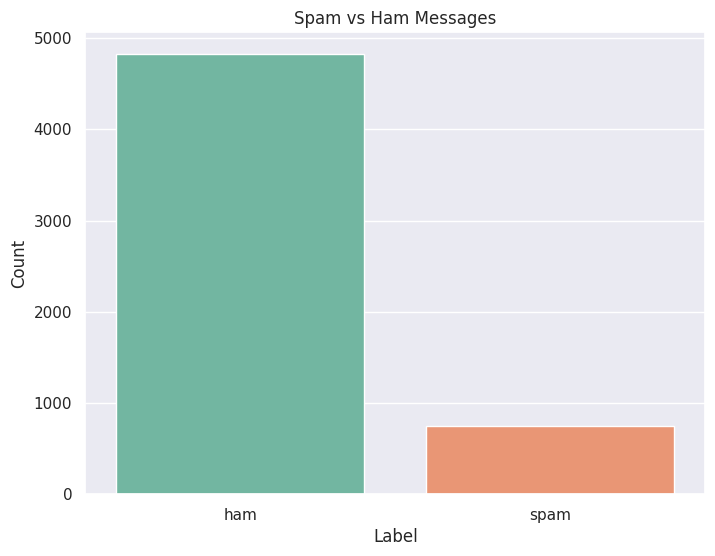

In [14]:
spam_ham_count = df['label'].value_counts()
sns.set(style='darkgrid')
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, palette='Set2')
plt.title('Spam vs Ham Messages')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [22]:
# Créer un jeu équilibré
spam_data = df[df['label'] == 'spam']
ham_data = df[df['label'] == 'ham']

# Je prend un sample de ham de même longueur que les spam
undersampled_ham_data = ham_data.sample(n=len(spam_data), random_state=42)
# Je comcat
balanced_data = pd.concat([spam_data, undersampled_ham_data])
# un shuffle et voilà mon nouveau dataset équilibré
df = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)


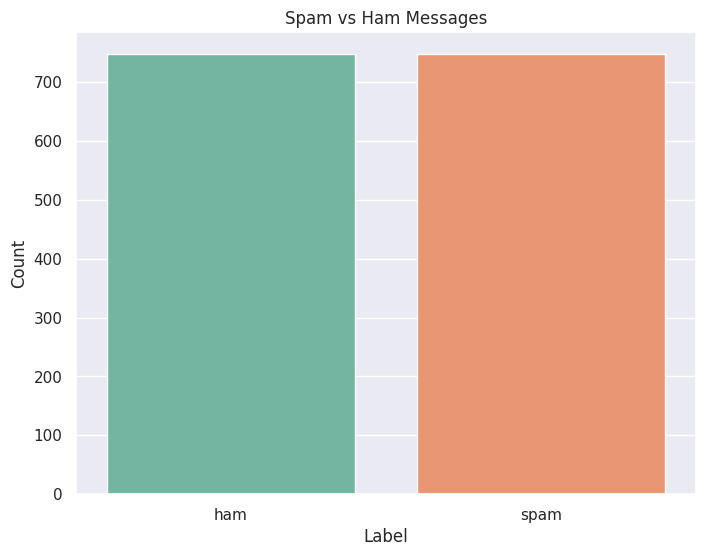

In [24]:
spam_ham_count = df['label'].value_counts()
sns.set(style='darkgrid')
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, palette='Set2')
plt.title('Spam vs Ham Messages')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [48]:
df.shape

(1494, 2)

#4. Automatisation du process avec un pipeline

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


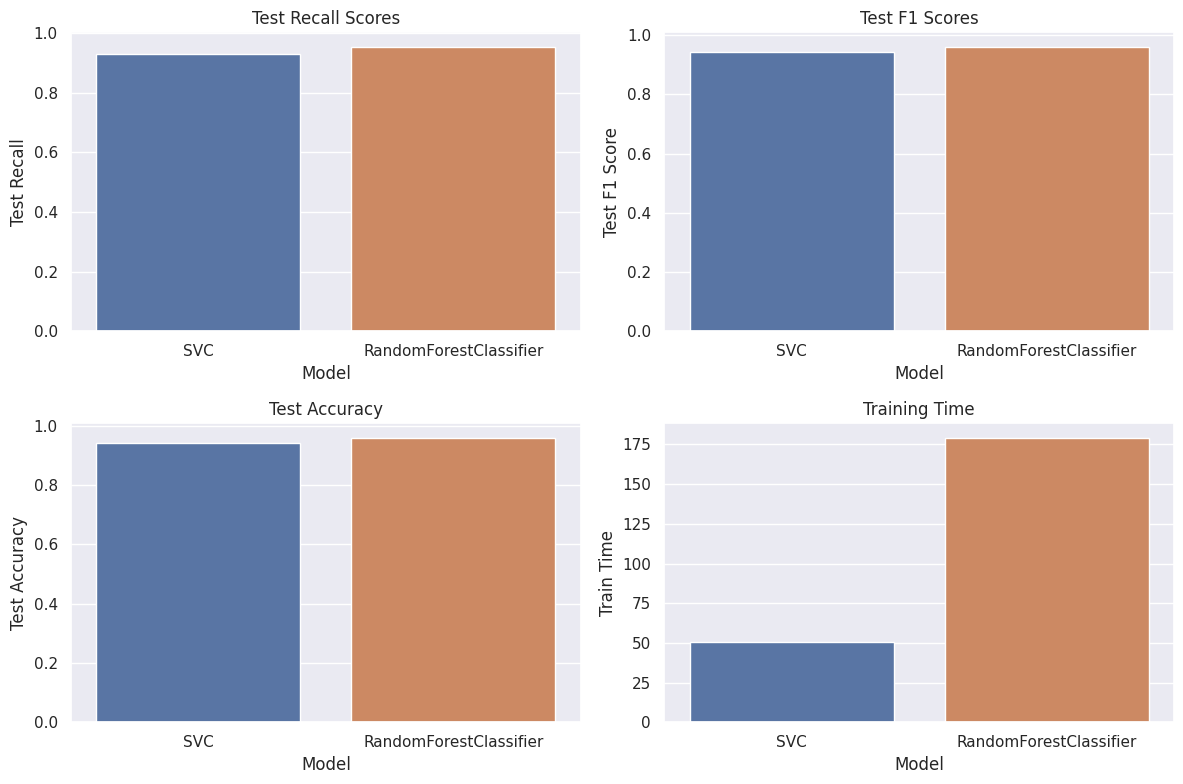

In [80]:
# Split the dataset into training and testing sets
X = df['message']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with TfidfVectorizer and classifiers (SVC and Random Forest)
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('classifier', SVC())  # Start with SVC
])

# Define the hyperparameters to tune
parameters = [
    {
        'vectorizer__max_features': [1000, 2000, 3000],
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'classifier': [SVC()],
        'classifier__C': [1, 10, 100],
        'classifier__gamma': [0.1, 0.01, 0.001]
    },
    {
        'vectorizer__max_features': [1000, 2000, 3000],
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 5, 10]
    }
]

# Define a list to store the results for each model
results = []

# Perform GridSearchCV for each set of hyperparameters
for params in parameters:
    grid_search = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='recall')
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time

    # Make predictions on the test set
    y_pred = grid_search.predict(X_test)

    # Calculate evaluation metrics
    train_recall = recall_score(y_train, grid_search.predict(X_train), pos_label='spam')
    test_recall = recall_score(y_test, y_pred, pos_label='spam', average='binary')
    test_f1 = f1_score(y_test, y_pred, pos_label='spam', average='binary')
    test_accuracy = accuracy_score(y_test, y_pred)

    # Store the results in a dictionary
    result = {
        'Model': grid_search.best_estimator_.named_steps['classifier'].__class__.__name__,
        'Train Recall': train_recall,
        'Test Recall': test_recall,
        'Test F1 Score': test_f1,
        'Test Accuracy': test_accuracy,
        'Train Time': train_time
    }
    results.append(result)

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Plot bar plots for metrics and training time
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.barplot(data=results_df, x='Model', y='Test Recall')
plt.title('Test Recall Scores')
plt.subplot(2, 2, 2)
sns.barplot(data=results_df, x='Model', y='Test F1 Score')
plt.title('Test F1 Scores')
plt.subplot(2, 2, 3)
sns.barplot(data=results_df, x='Model', y='Test Accuracy')
plt.title('Test Accuracy')
plt.subplot(2, 2, 4)
sns.barplot(data=results_df, x='Model', y='Train Time')
plt.title('Training Time')
plt.tight_layout()
plt.show()



In [81]:
results_df

,Model,Train Recall,Test Recall,Test F1 Score,Test Accuracy,Train Time
0,SVC,0.934122,0.929032,0.944262,0.943144,50.599915
1,RandomForestClassifier,0.996622,0.954839,0.961039,0.959866,179.346506


<Axes: >

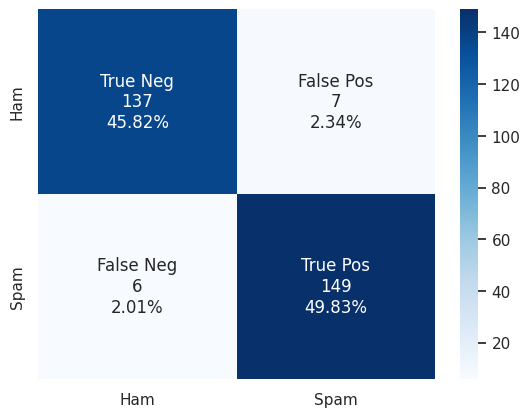

In [73]:
# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Display the confusion matrix with labeled categories and annotations

categories = ['Ham', 'Spam']

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_mat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_mat.flatten()/np.sum(confusion_mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(confusion_mat, annot=labels, fmt='', xticklabels=categories, yticklabels=categories, cmap='Blues')


## Choix du Recall comme metrics:

Recall = TP / (TP + FN)

Ici je voulais minimiser les mauvaise prédictions de spams quite à détecter des hams en tant que spam, mais je ne voulais pas passé à côté de spam.

## Meilleur model SVC pour son temps de d'entraînement et ses résultats issue du grid search cv